In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
# df_old_analysis = pd.read_csv(r"..\1_Data\df_analysis.csv")
df_original = pd.read_csv(r"..\1_Data\df_cleaned.csv")
df_analysis = df_original.copy()
df_ML = df_analysis.copy()

In [3]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37583 entries, 0 to 37582
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fullAddress            37583 non-null  object 
 1   postcode               37583 non-null  object 
 2   country                37583 non-null  object 
 3   outcode                37583 non-null  object 
 4   latitude               37583 non-null  float64
 5   longitude              37583 non-null  float64
 6   bathrooms              37583 non-null  float64
 7   bedrooms               37583 non-null  float64
 8   floorAreaSqM           37583 non-null  float64
 9   livingRooms            37583 non-null  float64
 10  tenure                 37583 non-null  object 
 11  propertyType           37583 non-null  object 
 12  currentEnergyRating    37583 non-null  object 
 13  soldYear               37583 non-null  int64  
 14  soldT                  37583 non-null  object 
 15  so

In [4]:
# 1. Total Rooms
df_ML['total_rooms'] = df_ML['bedrooms'] + df_ML['livingRooms']

# 2. Spatial Quality (No +0.1, as requested)
# Logic: A 60sqm house with 2 rooms (score 30) is a "Spacious Apartment".
#        A 60sqm house with 3 rooms (score 20) is a "Compact Apartment".
#        The model uses this to determine the "Style" of the property.
df_ML['spatial_quality'] = df_ML['floorAreaSqM'] / df_ML['total_rooms']

# 3. Luxury Index
# Logic: For small houses, this will mostly be 1.0 (Standard).
#        For big houses, 1.0 becomes rare and valuable.
#        The model uses Area + Index together to judge luxury.
#        We keep +0.1 here just in case a studio is listed as 0 bedrooms (studio flat)
df_ML['luxury_index'] = df_ML['bathrooms'] / (df_ML['bedrooms'] + 0.1)

In [5]:
df_ML.describe()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,soldYear,soldPrice,sqmPrice,in_conservation_area,sqm_approx,total_rooms,spatial_quality,luxury_index
count,37583.000000,37583.000000,37583.000000,37583.000000,37583.000000,37583.000000,37583.000000,3.758300e+04,37583.000000,37583.000000,37583.000000,37583.000000,37583.000000,37583.000000
mean,51.509197,-0.117340,1.485299,2.382833,100.520661,1.237368,2023.328473,8.119169e+05,7616.738752,0.289972,100.511668,3.620201,27.408782,0.674760
std,0.056477,0.089292,0.733059,1.290800,60.835119,0.611463,0.469664,9.214488e+05,3867.971948,0.453755,60.871258,1.736429,7.220751,0.258954
min,51.386653,-0.347055,1.000000,1.000000,10.000000,0.000000,2023.000000,1.000000e+04,66.230000,0.000000,10.000000,1.000000,9.500000,0.109890
25%,51.465565,-0.184005,1.000000,1.000000,59.000000,1.000000,2023.000000,3.750000e+05,5460.325000,0.000000,60.000000,2.000000,23.250000,0.476190
50%,51.501828,-0.120158,1.000000,2.000000,78.000000,1.000000,2023.000000,5.300000e+05,6854.840000,0.000000,80.000000,3.000000,26.400000,0.645161
75%,51.549781,-0.054122,2.000000,3.000000,129.000000,1.000000,2024.000000,9.050000e+05,8750.000000,1.000000,130.000000,5.000000,30.000000,0.909091
max,51.665454,0.138188,8.000000,9.000000,500.000000,7.000000,2024.000000,2.250000e+07,68613.330000,1.000000,500.000000,14.000000,250.000000,3.636364


In [6]:
# A. Convert Rooms to Integers
room_cols = ['bathrooms', 'bedrooms', 'livingRooms']
df_ML[room_cols] = df_analysis[room_cols].astype(int)

# B. Label Encode Energy Rating (Ordinal: A=7, G=1, NotRated=0)
energy_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1, 'NotRated': np.nan}
df_ML['energy_encoded'] = df_ML['currentEnergyRating'].map(energy_map)
energy_median = df_ML['energy_encoded'].median()
df_ML['is_energy_rated'] = df_ML['energy_encoded'].notna().astype(int)
df_ML['energy_encoded'] = df_ML['energy_encoded'].fillna(energy_median)

# C. One-Hot Encoding for categorical columns
# Drop the columns not needed
df_ML = df_ML.drop(columns=['soldT'])
df_ML = pd.get_dummies(df_ML, columns=['propertyType', 'tenure', 'construction_age_band'], drop_first=True, prefix=['prop', 'tenure', 'age'])

# D. Define features (X) and targets (y)
X = df_ML.drop(columns=['soldPrice']) 
y = np.log1p(df_ML['soldPrice'])

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target Encode Outcode (using median sqmPrice)
outcode_medians = X_train.groupby('outcode')['sqmPrice'].median()
global_median = X_train['sqmPrice'].median()
X_train['neighborhood_value'] = X_train['outcode'].map(outcode_medians)

X_test['neighborhood_value'] = X_test['outcode'].map(outcode_medians)
X_test['neighborhood_value'] = X_test['neighborhood_value'].fillna(global_median)

# E. Select final features (excluding the original strings and size_bucket)
final_features = [
    'neighborhood_value', 'bathrooms', 'bedrooms', 'floorAreaSqM', 
    'livingRooms', 'energy_encoded', 'is_energy_rated', 'tenure_Freehold', 'in_conservation_area', 'spatial_quality', 'luxury_index'
] + [col for col in df_ML.columns if 'propertyType_' in col or 'age' in col.lower()]

X_train = X_train[final_features].astype(float)
X_test = X_test[final_features].astype(float)

Training Random Forest
------------------------------
Model Performance:
------------------------------
R² Score: 0.7999 (The model explains 80.0% of the price variance)
RMSE:     £415,916 (Root Mean Squared Error)
MAE:      £176,345 (On average, the prediction is off by this amount)
MAPE:     26.91% (The average error percentage per house)
------------------------------


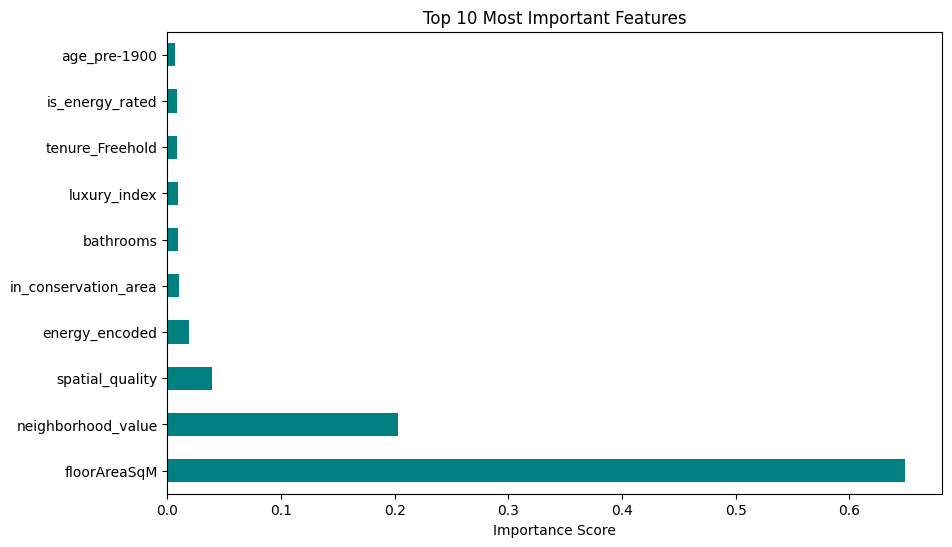

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# 1. Initialize the Forest
# n_estimators=100: The forest will build 100 decision trees.
# n_jobs=-1: Uses all your computer's processor cores to run faster.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model (Fit)
print("Training Random Forest")
rf_model.fit(X_train, y_train)

# 3. Predict on Test Data
y_pred = rf_model.predict(X_test)

# Inverse log transform
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

# Metrics
mse  = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_real, y_pred_real)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
r2   = r2_score(y_test_real, y_pred_real)

# 5. Display Results
print("-" * 30)
print("Model Performance:")
print("-" * 30)
print(f"R² Score: {r2:.4f} (The model explains {r2*100:.1f}% of the price variance)")
print(f"RMSE:     £{rmse:,.0f} (Root Mean Squared Error)")
print(f"MAE:      £{mae:,.0f} (On average, the prediction is off by this amount)")
print(f"MAPE:     {mape:.2%} (The average error percentage per house)")
print("-" * 30)

# Optional: Feature Importance
# See what matters most to the model

importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10,6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.show()

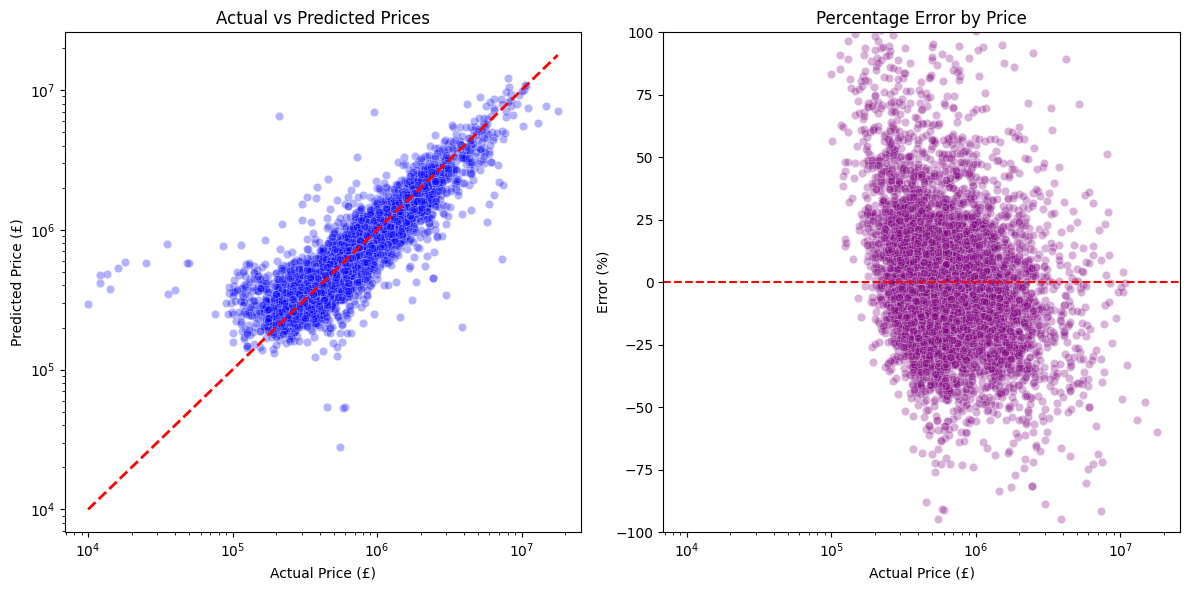

--- Analysis for ~£500k Houses ---
Average Error Amount: £89,360
Average Error %:      17.85%


In [9]:
# Create a DataFrame for plotting
results = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred_real
})

# Calculate the error for each specific house
results['Error_Amount'] = results['Predicted'] - results['Actual']
results['Error_Percent'] = (results['Error_Amount'] / results['Actual']) * 100

plt.figure(figsize=(12, 6))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.3, color='blue')
# Draw a red line for "Perfect Prediction"
plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', lw=2, linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.xscale('log') # Log scale helps see the spread better
plt.yscale('log')

# Plot 2: How big is the error at different price points?
plt.subplot(1, 2, 2)
sns.scatterplot(x='Actual', y='Error_Percent', data=results, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Percentage Error by Price')
plt.xlabel('Actual Price (£)')
plt.ylabel('Error (%)')
plt.xscale('log')
plt.ylim(-100, 100) # Zoom in to +/- 100% error

plt.tight_layout()
plt.show()

# Let's check the error specifically for houses around 500k
subset_500k = results[(results['Actual'] > 450000) & (results['Actual'] < 550000)]
avg_error_500k = subset_500k['Error_Amount'].abs().mean()
avg_mape_500k = subset_500k['Error_Percent'].abs().mean()

print(f"--- Analysis for ~£500k Houses ---")
print(f"Average Error Amount: £{avg_error_500k:,.0f}")
print(f"Average Error %:      {avg_mape_500k:.2f}%")

Starting Random Forest Grid Search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
------------------------------
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
------------------------------
Model Performance (Random Forest Grid Search):
------------------------------
R² Score: 0.7911
RMSE:     £424,997
MAE:      £173,076
MAPE:     25.57%
------------------------------


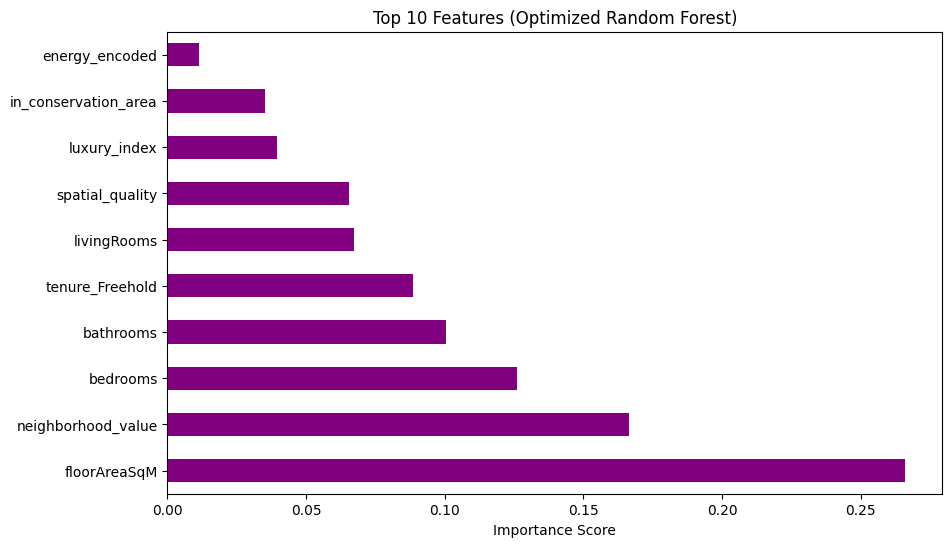

In [10]:
#  GRID SEARCH + CROSS VALIDATION

# 1. Define the Parameter Grid for Random Forest
# We try to balance complexity (depth) vs overfitting (min_samples)
param_grid = {
    'n_estimators': [100, 200],       # Try 100 and 200 trees (more is usually better but slower)
    'max_depth': [10, 20, None],      # None = full depth (can overfit), 10/20 = restricted
    'min_samples_split': [2, 5, 10],  # Higher numbers prevent the tree from learning specific noise
    'max_features': ['sqrt', 1.0]     # 'sqrt' looks at a subset of features (good for reducing variance)
}

# 2. Initialize the Base Model
# We set n_jobs=1 here to let the GridSearch handle the parallel processing
rf_base = RandomForestRegressor(random_state=42)

# 3. Setup the Grid Search
# n_jobs=-1 uses all cores to train different parameter combos at the same time
grid_search_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                              cv=3, scoring='neg_mean_absolute_error', 
                              verbose=1, n_jobs=-1)

# 4. Train (Fit) - "Finding the Best Watson"
print("Starting Random Forest Grid Search...")
grid_search_rf.fit(X_train, y_train)

# 5. Get the Winner
best_rf_model = grid_search_rf.best_estimator_
print("-" * 30)
print(f"Best Parameters: {grid_search_rf.best_params_}")
print("-" * 30)

# 6. Predict on Test Data (using the winner)
y_pred_log_gridCV = best_rf_model.predict(X_test)

# 7. Inverse Log Transform (Get Real £)
y_test_real_gridCV = np.expm1(y_test) # The actual answers
y_pred_real_gridCV = np.expm1(y_pred_log_gridCV) # The grid predictions

# 8. Metrics (All ending in _gridCV)
mse_gridCV  = mean_squared_error(y_test_real_gridCV, y_pred_real_gridCV)
rmse_gridCV = np.sqrt(mse_gridCV)
mae_gridCV  = mean_absolute_error(y_test_real_gridCV, y_pred_real_gridCV)
mape_gridCV = mean_absolute_percentage_error(y_test_real_gridCV, y_pred_real_gridCV)
r2_gridCV   = r2_score(y_test_real_gridCV, y_pred_real_gridCV)

# 9. Display Results
print("Model Performance (Random Forest Grid Search):")
print("-" * 30)
print(f"R² Score: {r2_gridCV:.4f}")
print(f"RMSE:     £{rmse_gridCV:,.0f}")
print(f"MAE:      £{mae_gridCV:,.0f}")
print(f"MAPE:     {mape_gridCV:.2%}")
print("-" * 30)

# 10. Feature Importance (From the Best Model)
importances_gridCV = best_rf_model.feature_importances_
feature_names = X_train.columns
feat_importances_gridCV = pd.Series(importances_gridCV, index=feature_names)

plt.figure(figsize=(10,6))
feat_importances_gridCV.nlargest(10).plot(kind='barh', color='purple')
plt.title("Top 10 Features (Optimized Random Forest)")
plt.xlabel("Importance Score")
plt.show()

In [11]:
# RANDOM SEARCH + CROSS VALIDATION

# 1. Define the Parameter Distribution (The "Wide Net")
# Instead of specific lists, we give ranges.
param_dist = {
    'n_estimators': randint(100, 600),        # Try any number between 100 and 600 trees
    'max_depth': [10, 20, 30, 40, 50, None],  # Explore deeper trees
    'min_samples_split': randint(2, 20),      # Try between 2 and 20
    'min_samples_leaf': randint(1, 10),       # New: Min samples to be a leaf (reduces noise)
    'max_features': ['sqrt', 1.0]             # Try both feature selection methods
}

# 2. Initialize Base Model
rf_base = RandomForestRegressor(random_state=42)

# 3. Setup Random Search
# n_iter=50 means "Try 50 random combinations"
# This is usually faster than a Grid Search but covers more ground
random_search = RandomizedSearchCV(estimator=rf_base, param_distributions=param_dist, 
                                   n_iter=50, cv=3, 
                                   scoring='neg_mean_absolute_error', 
                                   verbose=1, n_jobs=-1, random_state=42)

# 4. Train (Fit)
print("Starting Random Forest Random Search...")
random_search.fit(X_train, y_train)

# 5. Get the Winner
best_rf_rand = random_search.best_estimator_
print("-" * 30)
print(f"Best Parameters (Random): {random_search.best_params_}")
print("-" * 30)

# 6. Predict on Test Data
y_pred_log_randCV = best_rf_rand.predict(X_test)

# 7. Inverse Log Transform
y_test_real_randCV = np.expm1(y_test)
y_pred_real_randCV = np.expm1(y_pred_log_randCV)

# 8. Metrics (Ending in _randCV)
mse_randCV  = mean_squared_error(y_test_real_randCV, y_pred_real_randCV)
rmse_randCV = np.sqrt(mse_randCV)
mae_randCV  = mean_absolute_error(y_test_real_randCV, y_pred_real_randCV)
mape_randCV = mean_absolute_percentage_error(y_test_real_randCV, y_pred_real_randCV)
r2_randCV   = r2_score(y_test_real_randCV, y_pred_real_randCV)

# 9. Display Results
print("Model Performance (Random Search):")
print("-" * 30)
print(f"R² Score: {r2_randCV:.4f}")
print(f"RMSE:     £{rmse_randCV:,.0f}")
print(f"MAE:      £{mae_randCV:,.0f}")
print(f"MAPE:     {mape_randCV:.2%}")
print("-" * 30)

Starting Random Forest Random Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
------------------------------
Best Parameters (Random): {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 450}
------------------------------
Model Performance (Random Search):
------------------------------
R² Score: 0.8109
RMSE:     £404,356
MAE:      £169,445
MAPE:     25.86%
------------------------------


# 